<a href="https://colab.research.google.com/github/heghiw/lakovaci-linka/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Remove the existing directory
!rm -rf lakovaci-linka

# Clone the repository again
!git clone https://github.com/heghiw/lakovaci-linka.git

# Navigate to the directory
%cd lakovaci-linka


Cloning into 'lakovaci-linka'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 43 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 9.07 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/lakovaci-linka


data prep

In [2]:
import pandas as pd

# Define the path to the Excel file
file_path = '/content/lakovaci-linka/data1.xlsx'

# Read the sheet 'linka' into a DataFrame
linka_df = pd.read_excel(file_path, sheet_name='linka')

# Read the sheet 'recept' into a DataFrame
recept_df = pd.read_excel(file_path, sheet_name='recept')

print("Linka:")
print(linka_df)
print("\nRecepty:")
print(recept_df)



Linka:
             typ vany  id_vany   pozice_x_rel  pozice_x_cum
0               vstup         0           0.0           0.0
1        Teplý oplach         1        2300.0        2300.0
2             Postřik         2        1900.0        4200.0
3    Ponor odm železo         3        1900.0        6100.0
4    Ponor odm pozink         4        1800.0        7900.0
5            oplach 1         5        1800.0        9700.0
6            oplach 2         6        1800.0       11500.0
7       Moření železo         7        1800.0       13300.0
8       Moření pozink         8        1800.0       15100.0
9      Oplach moř žel         9        1800.0       16900.0
10  Oplach moř pozink        10        1800.0       18700.0
11    oplach společný        11        1800.0       20500.0
12           aktivace        12        1800.0       22300.0
13             fosfát        13        1800.0       24100.0
14             oplach        14        1800.0       25900.0
15            Oplach         21  

manipulator and vozik characteristics

In [3]:
linka_df.columns = linka_df.columns.str.strip()
recept_df.columns = recept_df.columns.str.strip()
print(linka_df.columns)
print(recept_df.columns)

Index(['typ vany', 'id_vany', 'pozice_x_rel', 'pozice_x_cum'], dtype='object')
Index(['tech', 'id_vany', 'poradi_operace', 'cas_min', 'cas_max', 'cas_opt',
       'okap', 'okap_cas'],
      dtype='object')


simulace


In [4]:
!pip install pulp

ver5


In [5]:
import pandas as pd
import numpy as np

def simulate_line_with_utilization(linka_df: pd.DataFrame,
                                   recept_df: pd.DataFrame,
                                   manipulator_characteristics: dict,
                                   tech: str = "tech1",
                                   num_manipulators: int = 6,
                                   num_products: int = 10):
    """
    Simulate a coating line with a repetitive cyclic schedule that is cascaded
    across multiple manipulators, each operating in a defined contiguous range.

    The recipe (recept_df) is filtered by tech and sorted by 'poradi_operace' so that
    the product’s forward sequence is defined (e.g. 0→1→2→...→20→100, with 100 as end-of-line).

    The overall sequence is partitioned into contiguous segments (ranges) using np.array_split;
    each range is assigned to one manipulator. The simulation is cascaded as follows:
      - A product enters the line from bath 0 to 1 only when bath 1 is free.
      - For each product, the transfer through each manipulator’s range is scheduled such that
        the manipulator only starts its assigned range when the product from the previous range is ready.
      - When a manipulator finishes its range, it “returns” to the start of its range (if needed) to
        be ready for the next product.

    The simulation then processes products sequentially, so that a new product is only started when
    the first manipulator (range 0) is ready. Only one product is allowed per bath at any time.

    Returns:
      - schedule_df: Detailed schedule of all move events (with absolute times) for all products.
      - ranges_df: DataFrame showing each manipulator's assigned bath range and its cycle time.
      - product_df: Summary of each product’s entry, exit, and cycle time.
      - sim_log_df: Chronological log of events (time, manipulator, move, product counts).
      - overall_takt: Overall cycle time (the maximum time a product takes to traverse all ranges).
    """
    # 1. Filter recipe and sort by poradi_operace.
    recipe = recept_df[recept_df['tech'] == tech].copy()
    if recipe.empty:
        raise ValueError(f"No recipe data found for tech '{tech}'.")
    recipe.sort_values('poradi_operace', inplace=True)
    tech_baths = recipe['id_vany'].tolist()
    if len(tech_baths) < 2:
        raise ValueError("Recipe must contain at least two baths.")
    print("Recipe-sorted bath sequence:", tech_baths)

    # 2. Build forward moves from consecutive baths.
    forward_moves = []
    for i in range(len(tech_baths) - 1):
        src = tech_baths[i]
        dst = tech_baths[i+1]
        if src != dst:
            forward_moves.append((src, dst))
    # If final bath is not 0 or 100, append a return move; if 100 then product exits.
    if tech_baths[-1] not in (0, 100):
        forward_moves.append((tech_baths[-1], 0))
    print("Forward moves (from -> to):", forward_moves)

    # 3. Build dwell map.
    dwell_map = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        d = row['cas_opt']
        if row['okap'] == 1:
            d += row['okap_cas']
        dwell_map[b] = d

    # 4. Process linka_df: keep valid rows and sort by cumulative position.
    linka_df_valid = linka_df[linka_df['pozice_x_rel'].notna()].copy()
    linka_df_valid.sort_values('pozice_x_cum', inplace=True)
    linka_df_valid.reset_index(drop=True, inplace=True)
    def get_position(bath_id):
        s = linka_df_valid.loc[linka_df_valid['id_vany'] == bath_id, 'pozice_x_cum']
        if s.empty:
            raise ValueError(f"Bath {bath_id} not found in linka_df.")
        return s.values[0]

    # 5. Compute movement times.
    def m_per_sec(m_per_min):
        return m_per_min / 60.0
    speed_up    = m_per_sec(manipulator_characteristics["speed_going_up"])
    speed_down  = m_per_sec(manipulator_characteristics["speed_going_down"])
    speed_near  = m_per_sec(manipulator_characteristics["speed_after_ponoreni"])
    speed_horiz = m_per_sec(manipulator_characteristics["speed_left_right"])
    highest_m = manipulator_characteristics["highest_point"] / 1000.0
    decel_m   = manipulator_characteristics["deceleration_point"] / 1000.0
    vertical_up = highest_m / speed_up
    time_down1  = (highest_m - decel_m) / speed_down
    time_down2  = decel_m / speed_near
    vertical_down = time_down1 + time_down2
    def compute_move_time(src, dst):
        pos_src = get_position(src)
        pos_dst = get_position(dst)
        dist = abs(pos_dst - pos_src) / 1000.0
        horiz_t = dist / speed_horiz
        return vertical_up + horiz_t + vertical_down

    # 6. Build steps list.
    steps = []
    for (src, dst) in forward_moves:
        t_move = compute_move_time(src, dst)
        t_dwell = dwell_map.get(dst, 0.0)
        steps.append({"src": src, "dst": dst, "move_time": t_move, "dwell": t_dwell, "total": t_move + t_dwell})

    # 7. Partition steps into contiguous groups for each manipulator.
    # We use np.array_split to divide the steps evenly.
    groups = np.array_split(np.array(steps), num_manipulators)
    manip_groups = [group.tolist() for group in groups]

    # 8. For each manipulator range, build a relative cycle schedule.
    # This schedule gives the time offsets (relative) for each move in that range.
    manip_schedule_records = {}
    manip_cycle_times = {}
    manip_ranges = {}
    for m in range(num_manipulators):
        group = manip_groups[m]
        current_t = 0.0
        rec_list = []
        baths_used = []
        for i, step in enumerate(group):
            start = current_t
            end = start + step["move_time"]
            rec_list.append({
                "StepIdx": i,
                "From": step["src"],
                "To": step["dst"],
                "StartTime (s)": round(start,2),
                "EndTime (s)": round(end,2),
                "MoveTime (s)": round(step["move_time"],2),
                "Dwell (s)": round(step["dwell"],2)
            })
            current_t = end + step["dwell"]
            baths_used.append(step["src"])
        if baths_used:
            baths_used.append(group[-1]["dst"])
        # If final bath in range is not 0 or 100, add return move for repositioning.
        if baths_used and (baths_used[-1] not in (0, 100)) and (len(baths_used) > 1):
            ret_t = compute_move_time(baths_used[-1], baths_used[0])
            rec_list.append({
                "StepIdx": "Return",
                "From": baths_used[-1],
                "To": baths_used[0],
                "StartTime (s)": round(current_t,2),
                "EndTime (s)": round(current_t+ret_t,2),
                "MoveTime (s)": round(ret_t,2),
                "Dwell (s)": 0
            })
            current_t += ret_t
        manip_schedule_records[m] = rec_list
        manip_cycle_times[m] = current_t
        manip_ranges[m] = baths_used

    overall_cycle = max(manip_cycle_times.values()) if manip_cycle_times else 0.0
    print("Overall cycle time (takt):", overall_cycle)

    # 9. Calculate product entry interval as the minimum EndTime of the first move (0->1) of manipulator 0.
    first_range = manip_schedule_records[0]
    possible_intervals = [rec["EndTime (s)"] for rec in first_range if rec["From"] == 0 and rec["To"] == 1]
    if possible_intervals:
        product_entry_interval = min(possible_intervals)
    elif product_entry_interval is None:
        product_entry_interval = overall_cycle / 2.0
    print("Product entry interval:", product_entry_interval)

    # 10. Simulate product flow across ranges sequentially.
    # Global product simulation: For each product, the product passes through range 0, then 1, etc.
    # Each manipulator's schedule is applied in sequence, and the product's arrival time at a range is the exit time from the previous range.
    schedule_records = []
    product_records = []

    # Initialize availability for each range (manipulator).
    range_free = {m: 0.0 for m in range(num_manipulators)}
    # Global product start time is when range 0 is free.
    current_global_time = 0.0

    for p in range(num_products):
        product_time = max(current_global_time, range_free[0])
        entry_time = product_time
        # Process each manipulator's range in order.
        for m in range(num_manipulators):
            # The relative schedule for manipulator m:
            rel_schedule = manip_schedule_records[m]
            # The absolute schedule for range m is obtained by adding an offset equal to the product's arrival at that range
            for rec in rel_schedule:
                abs_rec = rec.copy()
                abs_rec["Manipulator"] = m
                abs_rec["Product"] = p
                abs_rec["StartTime (s)"] += product_time
                abs_rec["EndTime (s)"] += product_time
                schedule_records.append(abs_rec)
            # Update product_time to the exit time of range m:
            if rel_schedule:
                product_time = product_time + manip_cycle_times[m]
            # Update the range's free time to product_time (i.e. range m is busy until then)
            range_free[m] = product_time
        exit_time = product_time
        product_records.append((p, entry_time, exit_time))
        # The next product can start only after range 0 is free.
        current_global_time = range_free[0]

    overall_cycle = max(exit for (_,_,exit) in product_records)
    product_df = pd.DataFrame(product_records, columns=["Product", "EntryTime (s)", "ExitTime (s)"])
    product_df["CycleTime (s)"] = product_df["ExitTime (s)"] - product_df["EntryTime (s)"]
    schedule_df = pd.DataFrame(schedule_records)

    # 11. Build simulation log.
    sim_log_records = []
    events_sorted = schedule_df.sort_values("StartTime (s)").copy()
    for _, event in events_sorted.iterrows():
        t = event["StartTime (s)"]
        prods_in = product_df[(product_df["EntryTime (s)"] <= t) & (product_df["ExitTime (s)"] > t)].shape[0]
        prods_out = product_df[product_df["ExitTime (s)"] <= t].shape[0]
        sim_log_records.append({
            "Time (s)": round(t, 2),
            "Manipulator": event["Manipulator"],
            "Action": f"Move {event['From']} -> {event['To']}",
            "Product": event["Product"],
            "Products In": prods_in,
            "Products Out": prods_out
        })
    sim_log_df = pd.DataFrame(sim_log_records)

    # 12. Build ranges DataFrame.
    range_records = []
    for m, baths in manip_ranges.items():
        if baths:
            pos_start = get_position(baths[0])
            pos_end = get_position(baths[-1])
        else:
            pos_start = pos_end = None
        range_records.append({
            "Manipulator": m,
            "Bath Range": baths,
            "Position Range (mm)": f"{pos_start} to {pos_end}" if pos_start is not None else "",
            "Cycle Time (s)": round(manip_cycle_times.get(m, 0.0), 2)
        })
    ranges_df = pd.DataFrame(range_records)

    overall_takt = overall_cycle  # Each product takes one full cycle.

    return schedule_df, ranges_df, product_df, sim_log_df, overall_takt

if __name__ == "__main__":
    # Load your data for linka_df and recept_df.
    # For example:
    # linka_df = pd.read_excel("data.xlsx", sheet_name="linka")
    # recept_df = pd.read_excel("data.xlsx", sheet_name="recept")


    manipulator_characteristics = {
        "okap_point": 2000, #
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

    schedule_df, ranges_df, product_df, sim_log_df, overall_takt = simulate_line_with_utilization(
        linka_df=linka_df,
        recept_df=recept_df,
        manipulator_characteristics=manipulator_characteristics,
        tech="tech3",
        num_manipulators=6,
        num_products=10
    )

    print("=== Manipulator Movement Schedule (One Cycle, repeated for each product) ===")
    print(schedule_df.to_string(index=False))
    print("\n=== Manipulator Ranges and Cycle Times ===")
    print(ranges_df.to_string(index=False))
    print("\n=== Product Cycle Summary ===")
    print(product_df.to_string(index=False))
    print("\n=== Simulation Log ===")
    print(sim_log_df.to_string(index=False))
    print(f"\nOverall Takt (Cycle Time) = {overall_takt:.2f} s")


Recipe-sorted bath sequence: [0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 14, 21, 15, 16, 17, 18, 19, 20, 100]
Forward moves (from -> to): [(0, 1), (1, 2), (2, 4), (4, 5), (5, 6), (6, 8), (8, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 21), (21, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 100)]
Overall cycle time (takt): 727.5142857142857
Product entry interval: 29.94
=== Manipulator Movement Schedule (One Cycle, repeated for each product) ===
StepIdx  From  To  StartTime (s)  EndTime (s)  MoveTime (s)  Dwell (s)  Manipulator  Product
      0     0   1       0.000000    29.940000         29.94        140            0        0
      1     1   2     169.940000   199.200000         29.26         90            0        0
      2     2   4     289.200000   321.540000         32.34        110            0        0
      3     4   5     431.540000   460.630000         29.09         75            0        0
 Return     5   0     535.630000   578.260000         42.63          0  

In [6]:
    sim_log_df.to_excel("simulation_log.xlsx", index=False)
    print("\nSimulation log saved as 'simulation_log.xlsx'.")


Simulation log saved as 'simulation_log.xlsx'.


ver2

In [7]:
import pandas as pd
import numpy as np
import pulp

# ====================================================
# Helper Function: Get Optimal Dwell Time for a Bath
# ====================================================
def optimal_dwell_val(b, recipe_df):
    # Returns the "optimal" dwell time for bath b:
    # if okap == 1 then cas_opt + okap_cas, else cas_opt.
    row = recipe_df[recipe_df['id_vany'] == b]
    if row.empty:
        return None
    row = row.iloc[0]
    if row['okap'] == 1:
        return float(row['cas_opt']) + float(row['okap_cas'])
    else:
        return float(row['cas_opt'])

# ====================================================
# Stage 0: Common Helper Functions
# ====================================================
def m_per_sec(m_per_min):
    return m_per_min / 60.0

def compute_move_time(src, dst, linka_df, manip_char):
    pos_src = float(linka_df.loc[linka_df['id_vany'] == src, 'pozice_x_cum'].values[0])
    pos_dst = float(linka_df.loc[linka_df['id_vany'] == dst, 'pozice_x_cum'].values[0])
    speed_horiz = m_per_sec(manip_char["speed_left_right"])
    speed_up    = m_per_sec(manip_char["speed_going_up"])
    speed_down  = m_per_sec(manip_char["speed_going_down"])
    speed_near  = m_per_sec(manip_char["speed_after_ponoreni"])
    highest_m   = manip_char["highest_point"] / 1000.0
    decel_m     = manip_char["deceleration_point"] / 1000.0
    vertical_up   = highest_m / speed_up
    time_down1    = (highest_m - decel_m) / speed_down
    time_down2    = decel_m / speed_near
    vertical_down = time_down1 + time_down2
    dist_m = abs(pos_dst - pos_src) / 1000.0
    horiz_t = dist_m / speed_horiz
    return vertical_up + horiz_t + vertical_down

def build_forward_moves(recipe, linka_df, manip_char):
    tech_baths = recipe['id_vany'].tolist()
    forward_moves = []
    for i in range(len(tech_baths) - 1):
        src = tech_baths[i]
        dst = tech_baths[i+1]
        if src != dst:
            t_move = compute_move_time(src, dst, linka_df, manip_char)
            forward_moves.append({
                "src": src,
                "dst": dst,
                "t_move": t_move
            })
    if tech_baths[-1] not in (0, 100):
        forward_moves.append({
            "src": tech_baths[-1],
            "dst": 0,
            "t_move": compute_move_time(tech_baths[-1], 0, linka_df, manip_char)
        })
    return forward_moves

# ====================================================
# Stage 1: Corridor Segmentation with Fixed (Optimal) Dwell Times
# ====================================================
def optimize_corridors_fixed(recipe, forward_moves, manip_char, linka_df, num_manipulators):
    # Use the recipe's optimal dwell: dwell = cas_opt (+ okap_cas if okap==1)
    dwell_map_fixed = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        d = float(row['cas_opt'])
        if row['okap'] == 1:
            d += float(row['okap_cas'])
        dwell_map_fixed[b] = d

    N = len(forward_moves)
    t = [0]
    for move in forward_moves:
        t.append(move["t_move"] + dwell_map_fixed.get(move["dst"], 0.0))

    C = [0]
    for i in range(1, N+1):
        C.append(C[i-1] + t[i])

    R = {}
    for i in range(1, N+1):
        for j in range(i, N+1):
            if j == N:
                R[(i,j)] = 0
            else:
                last_bath = forward_moves[j-1]["dst"]
                first_bath = forward_moves[i-1]["src"]
                if last_bath not in (0, 100):
                    R[(i,j)] = compute_move_time(last_bath, first_bath, linka_df, manip_char)
                else:
                    R[(i,j)] = 0

    arcs = [(i, j) for i in range(1, N+1) for j in range(i+1, N+2)]
    arc_cost = {}
    for (i, j) in arcs:
        arc_cost[(i, j)] = (C[j-1] - C[i-1]) + R[(i, j-1)]

    M_value = C[N] + max(R.values())

    model = pulp.LpProblem("Corridor_Segmentation_Fixed", pulp.LpMinimize)
    X = pulp.LpVariable.dicts("X", arcs, 0, 1, pulp.LpBinary)
    Z = pulp.LpVariable("Z", lowBound=0, cat=pulp.LpContinuous)

    model += Z, "Minimize_max_corridor_cost"
    model += pulp.lpSum([X[(1,j)] for j in range(2, N+2)]) == 1, "Start_from_1"
    model += pulp.lpSum([X[(i, N+1)] for i in range(1, N+1)]) == 1, "End_at_Nplus1"
    for i in range(2, N+1):
        model += (pulp.lpSum([X[(k,i)] for k in range(1, i)]) ==
                  pulp.lpSum([X[(i,j)] for j in range(i+1, N+2)])), f"Flow_node_{i}"
    model += pulp.lpSum([X[(i,j)] for (i,j) in arcs]) == num_manipulators, "Total_corridors"
    for (i, j) in arcs:
        model += Z >= arc_cost[(i,j)] - M_value*(1 - X[(i,j)]), f"ArcCost_{i}_{j}"

    solver = pulp.PULP_CBC_CMD(msg=False)
    model.solve(solver)
    print("Stage 1 MILP Status:", pulp.LpStatus[model.status])
    print("Stage 1 Optimal max corridor cost (takt) = {:.2f} s".format(pulp.value(Z)))

    corridors = []
    current_node = 1
    while current_node < N+1:
        for j in range(current_node+1, N+2):
            if pulp.value(X[(current_node,j)]) > 0.5:
                corridors.append((current_node, j-1))
                current_node = j
                break

    corridor_info = []
    for (i, j) in corridors:
        cost = (C[j] - C[i-1]) + R[(i,j)]
        first_bath = forward_moves[i-1]["src"]
        last_bath  = forward_moves[j-1]["dst"]
        corridor_info.append({
            "Corridor": len(corridor_info),
            "Moves": (i, j),
            "Bath Range": [first_bath, last_bath],
            "Cycle Time (s)": round(cost, 2)
        })
    return corridor_info, dwell_map_fixed

# ====================================================
# Stage 2: Optimize Dwell Times via Unified Cost Function
# ====================================================
def optimize_dwell_times(corridor_info, forward_moves, recipe, linka_df, manip_char, num_manipulators, alpha=1, gamma=100):
    dwell_bounds = {}
    optimal_dwell = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        if b in (0, 100):
            continue
        lb = float(row['cas_min'])
        ub = float(row['cas_max'])
        if row['okap'] == 1:
            opt_val = float(row['cas_opt']) + float(row['okap_cas'])
        else:
            opt_val = float(row['cas_opt'])
        dwell_bounds[b] = (lb, ub)
        optimal_dwell[b] = opt_val

    unique_baths = set(move["dst"] for move in forward_moves)
    y = {}
    for b in unique_baths:
        if b in dwell_bounds:
            lb, ub = dwell_bounds[b]
            y[b] = pulp.LpVariable(f"y_{b}", lb, ub, cat=pulp.LpContinuous)

    N = len(forward_moves)
    corridor_cycle = []
    for idx, (i, j) in enumerate([info["Moves"] for info in corridor_info]):
        expr = 0
        for k in range(i, j+1):
            move = forward_moves[k-1]
            b = move["dst"]
            if b in y:
                expr += move["t_move"] + y[b]
            else:
                expr += move["t_move"]
        if forward_moves[j-1]["dst"] not in (0, 100):
            expr += compute_move_time(forward_moves[j-1]["dst"], forward_moves[i-1]["src"], linka_df, manip_char)
        corridor_cycle.append(expr)

    M = pulp.LpVariable("M", lowBound=0, cat=pulp.LpContinuous)
    for idx, cycle_expr in enumerate(corridor_cycle):
        pulp.LpConstraint(e= M - cycle_expr, sense=pulp.LpConstraintGE, rhs=0, name=f"Cycle_corridor_{idx}")
    v = pulp.LpVariable("v", lowBound=0, cat=pulp.LpContinuous)
    pulp.LpConstraint(e = v - (M - 300), sense=pulp.LpConstraintGE, rhs=0, name="Penalty_over_300")

    z = {}
    for b in y:
        z[b] = pulp.LpVariable(f"z_{b}", lowBound=0, cat=pulp.LpContinuous)

    dwell_model = pulp.LpProblem("Optimize_Dwell_Times", pulp.LpMinimize)
    dwell_model += alpha * pulp.lpSum([z[b] for b in z]) + gamma * v, "Total_Cost"

    for b in y:
        dwell_model += y[b] - optimal_dwell[b] <= z[b], f"Dev1_b{b}"
        dwell_model += optimal_dwell[b] - y[b] <= z[b], f"Dev2_b{b}"

    for idx, cycle_expr in enumerate(corridor_cycle):
        dwell_model += M >= cycle_expr, f"Cycle_corridor_{idx}"

    dwell_model += v >= M - 300, "Penalty_over_300"

    solver = pulp.PULP_CBC_CMD(msg=False)
    dwell_model.solve(solver)
    print("\nStage 2 MILP Status:", pulp.LpStatus[dwell_model.status])
    print("Optimized overall cycle time M = {:.2f} s".format(pulp.value(M)))
    print("Penalty v = {:.2f} s".format(pulp.value(v)))

    optimized_dwell = {b: pulp.value(y[b]) for b in y}

    optimized_corridor_info = []
    for idx, info in enumerate(corridor_info):
        i, j = info["Moves"]
        cycle_time = 0
        bath_seq = []
        for k in range(i, j+1):
            move = forward_moves[k-1]
            bath_seq.append(move["src"])
            b = move["dst"]
            d_val = optimized_dwell.get(b, 0)
            cycle_time += move["t_move"] + d_val
        bath_seq.append(forward_moves[j-1]["dst"])
        if forward_moves[j-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(forward_moves[j-1]["dst"], forward_moves[i-1]["src"], linka_df, manip_char)
            cycle_time += ret_time
        optimized_corridor_info.append({
            "Corridor": info["Corridor"],
            "Moves": info["Moves"],
            "Bath Sequence": bath_seq,
            "Optimized Cycle Time (s)": round(cycle_time, 2)
        })
    return optimized_dwell, optimized_corridor_info, pulp.value(M)

# ====================================================
# Simulation: Decoupled Dwell Scenario
# ====================================================
def simulate_pipeline_decoupled(opt_corridor_info, forward_moves, optimized_dwell, num_products, linka_df, manip_char):
    """
    For decoupled dwell, the manipulator’s active cycle time excludes dwell delays.
    The product’s readiness is delayed by the dwell times.
    """
    m = len(opt_corridor_info)
    cycle_no_dwell = []
    delays = []
    for info in opt_corridor_info:
        i_start, i_end = info["Moves"]
        moves = forward_moves[i_start-1 : i_end]
        move_sum = sum(move["t_move"] for move in moves)
        delay_sum = sum(optimized_dwell.get(move["dst"], 0) for move in moves)
        if moves[-1]["dst"] not in (0, 100):
            ret = compute_move_time(moves[-1]["dst"], moves[0]["src"], linka_df, manip_char)
        else:
            ret = 0
        cycle_no_dwell.append(move_sum + ret)
        delays.append(delay_sum)
    bottleneck = max(cycle_no_dwell)
    T_dec = np.zeros((num_products, m))
    F_dec = np.zeros((num_products, m))
    ready = np.zeros((num_products, m))
    for p in range(num_products):
        T_dec[p,0] = p * bottleneck
        F_dec[p,0] = T_dec[p,0] + cycle_no_dwell[0]
        ready[p,0] = F_dec[p,0] + delays[0]
    for i in range(1, m):
        T_dec[0,i] = ready[0,i-1]
        F_dec[0,i] = T_dec[0,i] + cycle_no_dwell[i]
        ready[0,i] = F_dec[0,i] + delays[i]
        for p in range(1, num_products):
            T_dec[p,i] = max(F_dec[p,i-1], F_dec[p-1,i])
            F_dec[p,i] = T_dec[p,i] + cycle_no_dwell[i]
            ready[p,i] = F_dec[p,i] + delays[i]
    events = []
    for i in range(m):
        for p in range(num_products):
            events.append({
                "Time (s)": T_dec[p,i],
                "Manipulator": i,
                "Action": f"Start Corridor {i} (active move: {cycle_no_dwell[i]:.2f} s)",
                "Product": p
            })
            events.append({
                "Time (s)": F_dec[p,i],
                "Manipulator": i,
                "Action": f"End Corridor {i}",
                "Product": p
            })
    events = sorted(events, key=lambda x: x["Time (s)"])
    sim_log = []
    for event in events:
        t_event = event["Time (s)"]
        prods_in = sum(T_dec[p,0] <= t_event for p in range(num_products))
        prods_out = sum(F_dec[p,m-1] <= t_event for p in range(num_products))
        sim_log.append({
            "Time (s)": round(t_event,2),
            "Manipulator": event["Manipulator"],
            "Action": event["Action"],
            "Product": event["Product"],
            "Products In": prods_in,
            "Products Out": prods_out
        })
    sim_log_df = pd.DataFrame(sim_log)
    return T_dec, F_dec, sim_log_df, cycle_no_dwell, delays

# ====================================================
# Detailed Move Sequence Table (Decoupled Dwell)
# ====================================================
def generate_detailed_move_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manip_char):
    """
    For each corridor, generate a table with columns:
    [StepIdx, From, To, StartTime (s), EndTime (s), MoveTime (s), Dwell (s), Manipulator, Product]
    where times are relative to the cycle start (product cycle = active moves + dwell delays).
    """
    rows = []
    # We'll assume Product = 0 for the cycle schedule.
    for info in opt_corridor_info:
        seg = info["Moves"]
        manip = info["Corridor"]
        moves = forward_moves[seg[0]-1 : seg[1]]  # 0-indexed list of moves for the corridor
        current_time = 0.0
        step_idx = 0
        # Process each move:
        for move in moves:
            start_time = current_time
            end_time = start_time + move["t_move"]
            dwell_time = optimized_dwell.get(move["dst"], 0)
            rows.append({
                "StepIdx": step_idx,
                "From": move["src"],
                "To": move["dst"],
                "StartTime (s)": round(start_time, 2),
                "EndTime (s)": round(end_time, 2),
                "MoveTime (s)": round(move["t_move"], 2),
                "Dwell (s)": round(dwell_time, 2),
                "Manipulator": manip,
                "Product": 0
            })
            current_time = end_time + dwell_time
            step_idx += 1
        # Add return move if needed:
        if moves[-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(moves[-1]["dst"], moves[0]["src"], linka_df, manip_char)
            start_time = current_time
            end_time = start_time + ret_time
            rows.append({
                "StepIdx": "Return",
                "From": moves[-1]["dst"],
                "To": moves[0]["src"],
                "StartTime (s)": round(start_time, 2),
                "EndTime (s)": round(end_time, 2),
                "MoveTime (s)": round(ret_time, 2),
                "Dwell (s)": 0,
                "Manipulator": manip,
                "Product": 0
            })
            current_time = end_time
        # For clarity, you might also print the final cycle time for the corridor.
        rows.append({
            "StepIdx": "CycleTime",
            "From": "",
            "To": "",
            "StartTime (s)": "",
            "EndTime (s)": "",
            "MoveTime (s)": round(current_time, 2),
            "Dwell (s)": "",
            "Manipulator": manip,
            "Product": 0
        })
    df = pd.DataFrame(rows)
    return df

# ====================================================
# Final Cycle Schedule Printout (Decoupled Version)
# ====================================================
def print_final_cycle_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manip_char):
    print("\n=== Final Program for Each Manipulator (Decoupled Dwell) ===")
    for info in opt_corridor_info:
        seg = info.get("Moves")
        bath_seq = info.get("Bath Sequence")
        manip = info["Corridor"]
        if bath_seq is None:
            seg = info["Moves"]
            bath_seq = [forward_moves[seg[0]-1]["src"]]
            for k in range(seg[0]-1, seg[1]):
                bath_seq.append(forward_moves[k]["dst"])
        # Calculate active move time
        move_sum = sum(forward_moves[k-1]["t_move"] for k in range(seg[0], seg[1]+1))
        if forward_moves[seg[1]-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(forward_moves[seg[1]-1]["dst"], forward_moves[seg[0]-1]["src"], linka_df, manip_char)
        else:
            ret_time = 0
        active_cycle = move_sum + ret_time
        delay_sum = sum(optimized_dwell.get(forward_moves[k-1]["dst"], 0) for k in range(seg[0], seg[1]+1))
        overall_cycle = active_cycle + delay_sum
        print(f"\nManipulator {manip}:")
        print(f"  Bath Sequence: {bath_seq}")
        print(f"  Active Cycle Time (manipulator moves): {active_cycle:.2f} s")
        print(f"  Total Product Dwell Delay: {delay_sum:.2f} s")
        print(f"  Overall Product Cycle Time: {overall_cycle:.2f} s")

# ====================================================
# Main Script
# ====================================================
if __name__ == "__main__":
    # ----- Provided Linka Data -----

    linka_df = linka_df[linka_df["pozice_x_rel"].notna()].copy()


    recept_df.sort_values("poradi_operace", inplace=True)

    # ----- Manipulator Characteristics -----
    manipulator_characteristics = {
        "okap_point": 2000,
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

    tech = "tech2"
    num_manipulators = 6

    # Filter recipe for chosen tech
    recipe = recept_df[recept_df['tech'] == tech].copy()
    if recipe.empty:
        raise ValueError(f"No recipe found for tech '{tech}'.")

    # ----- Stage 1: Fixed Segmentation Using Optimal Dwell Times -----
    forward_moves = build_forward_moves(recipe, linka_df, manipulator_characteristics)
    print("Forward moves (bath transitions):")
    for move in forward_moves:
        print(f"  {move['src']} -> {move['dst']} (move time: {move['t_move']:.2f} s)")

    corridor_info, dwell_map_fixed = optimize_corridors_fixed(recipe, forward_moves, manipulator_characteristics, linka_df, num_manipulators)
    print("\n=== Stage 1: Fixed Corridor Segmentation ===")
    for info in corridor_info:
        print(f"Manipulator {info['Corridor']}: Bath Range {info['Bath Range']}, Full Cycle Time = {info['Cycle Time (s)']} s")
    baseline_takt = max(info['Cycle Time (s)'] for info in corridor_info)
    print(f"\nBaseline Takt (with fixed dwell) = {baseline_takt:.2f} s")

    # ----- Stage 2: Optimize Dwell Times via Unified Cost Function -----
    alpha = 1
    gamma = 100
    optimized_dwell, opt_corridor_info, M_val = optimize_dwell_times(corridor_info, forward_moves, recipe, linka_df, manipulator_characteristics, num_manipulators, alpha, gamma)
    print("\n=== Stage 2: Optimized Dwell Times ===")
    print("Optimized dwell times (seconds):")
    for b in sorted(optimized_dwell.keys()):
        print(f"  Bath {b}: {optimized_dwell[b]:.2f} s (optimal = {optimal_dwell_val(b, recipe):.2f} s)")
    print("\nOptimized Corridor Cycle Times:")
    for info in opt_corridor_info:
        print(f"Manipulator {info['Corridor']}: Bath Sequence {info['Bath Sequence']}, Optimized Cycle Time = {info['Optimized Cycle Time (s)']} s")
    print(f"\nOptimized Overall Cycle Time M = {M_val:.2f} s")

    # ----- Simulation: Decoupled Dwell Scenario -----
    num_products = 10
    T_dec, F_dec, sim_log_dec, cycle_no_dwell, delays = simulate_pipeline_decoupled(opt_corridor_info, forward_moves, optimized_dwell, num_products, linka_df, manipulator_characteristics)
    print("\n=== Detailed Simulation Log (Decoupled Dwell) ===")
    print(sim_log_dec.to_string(index=False))

    # ----- Detailed Move Sequence Table -----
    move_schedule_df = generate_detailed_move_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manipulator_characteristics)
    print("\n=== Detailed Move Sequence for Each Manipulator (One Cycle) ===")
    print(move_schedule_df.to_string(index=False))

    # ----- Final Cycle Schedule (Decoupled Version) -----
    print_final_cycle_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manipulator_characteristics)


Forward moves (bath transitions):
  0 -> 1 (move time: 29.94 s)
  1 -> 2 (move time: 29.26 s)
  2 -> 3 (move time: 29.26 s)
  3 -> 5 (move time: 32.17 s)
  5 -> 6 (move time: 29.09 s)
  6 -> 11 (move time: 41.43 s)
  11 -> 12 (move time: 29.09 s)
  12 -> 13 (move time: 29.09 s)
  13 -> 14 (move time: 29.09 s)
  14 -> 21 (move time: 29.09 s)
  21 -> 15 (move time: 29.09 s)
  15 -> 16 (move time: 29.09 s)
  16 -> 17 (move time: 29.94 s)
  17 -> 18 (move time: 29.94 s)
  18 -> 19 (move time: 29.09 s)
  19 -> 20 (move time: 29.09 s)
  20 -> 100 (move time: 29.94 s)
Stage 1 MILP Status: Optimal
Stage 1 Optimal max corridor cost (takt) = 650.89 s

=== Stage 1: Fixed Corridor Segmentation ===
Manipulator 0: Bath Range [0, 2], Full Cycle Time = 392.4 s
Manipulator 1: Bath Range [2, 11], Full Cycle Time = 650.89 s
Manipulator 2: Bath Range [11, 13], Full Cycle Time = 620.34 s
Manipulator 3: Bath Range [13, 16], Full Cycle Time = 534.69 s
Manipulator 4: Bath Range [16, 19], Full Cycle Time = 547

In [8]:
def plot_detailed_move_schedule(df):
    """
    Given a move schedule DataFrame (from generate_detailed_move_schedule_decoupled),
    plot a Gantt-chart style diagram showing active move segments and dwell segments
    for each manipulator.
    """
    import matplotlib.pyplot as plt

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors: one for moves, one for dwell segments.
    move_color = 'skyblue'
    dwell_color = 'salmon'

    # We'll group the table by manipulator.
    grouped = df[df["StepIdx"] != "CycleTime"].groupby("Manipulator")

    for manip, group in grouped:
        # For each row in the group, plot the move and then the dwell (if dwell > 0)
        for idx, row in group.iterrows():
            start = row["StartTime (s)"]
            end = row["EndTime (s)"]
            # Compute the move duration and dwell duration from the table:
            move_duration = row["MoveTime (s)"]
            dwell_duration = row["Dwell (s)"]
            # Plot active move segment (from start to start+move_duration)
            ax.broken_barh([(start, move_duration)], (manip*10, 3), facecolors=move_color, edgecolor="black")
            # Label the move step (using the step index)
            ax.text(start + move_duration/2, manip*10 + 1.5, f"{row['StepIdx']}", ha="center", va="center", fontsize=8)
            # If there is a dwell period, plot that next to the move segment.
            if dwell_duration > 0:
                ax.broken_barh([(start+move_duration, dwell_duration)], (manip*10, 3), facecolors=dwell_color, edgecolor="black")
                ax.text(start+move_duration+dwell_duration/2, manip*10 + 1.5, "Dwell", ha="center", va="center", fontsize=8, color="black")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Manipulator")
    # Set y-ticks so that each manipulator is labeled
    num_manipulators = df["Manipulator"].max() + 1
    ax.set_yticks([i*10+1.5 for i in range(num_manipulators)])
    ax.set_yticklabels([f"Manipulator {i}" for i in range(num_manipulators)])
    ax.set_title("Detailed Move Schedule (One Cycle, Decoupled Dwell)")
    plt.tight_layout()
    plt.show()


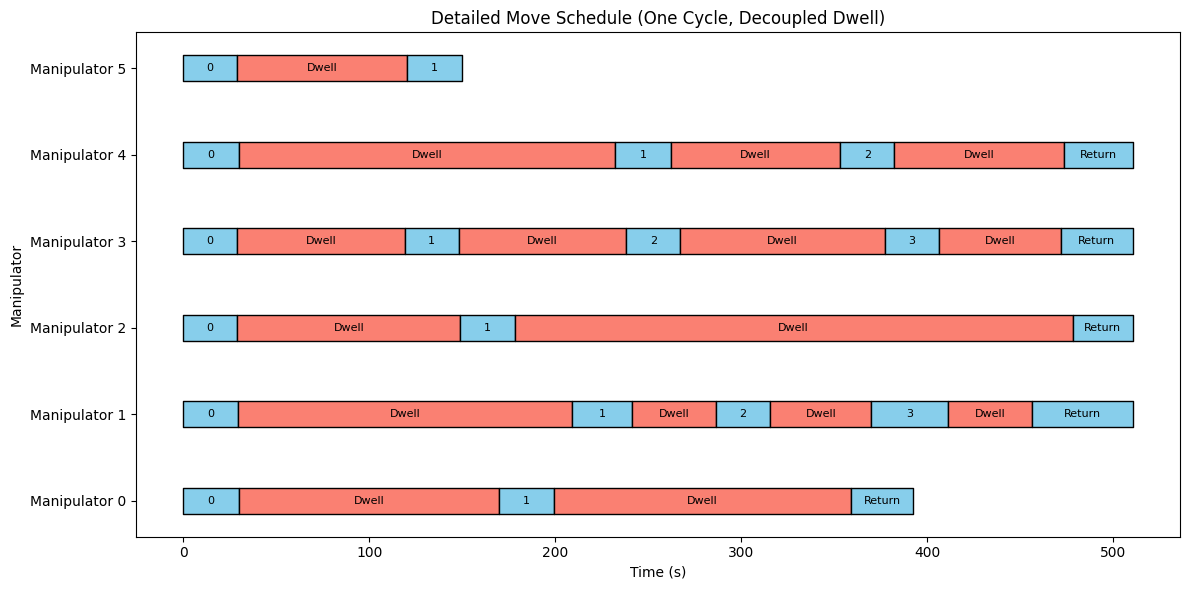

In [9]:
plot_detailed_move_schedule(move_schedule_df)


ver2.2 where manipulators learn to go back

In [10]:
!pip install ortools

In [11]:
import pandas as pd
import numpy as np
from ortools.sat.python import cp_model

manipulator_characteristics = {
        "okap_point": 2000,
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

CYCLE_TIME_LIMIT=300

###########################################
# Part A: Optimal Corridor Segmentation
###########################################

def optimal_partition(T, n):
    """
    Partition the sequence T (list of active move times between consecutive baths)
    into n segments so that the maximum segment sum is minimized.

    Returns: (min_max, breakpoints, c)
      - min_max: minimized maximum segment sum,
      - breakpoints: list of indices in T where the segments should break,
      - c: cumulative sum array of T.
    """
    N = len(T)
    c = [0] * (N + 1)
    for i in range(1, N+1):
        c[i] = c[i-1] + T[i-1]

    dp = [[float('inf')] * (n+1) for _ in range(N+1)]
    dp[0][0] = 0
    for i in range(1, N+1):
        dp[i][1] = c[i]

    breakpoints = [[-1]*(n+1) for _ in range(N+1)]

    for j in range(2, n+1):
        for i in range(j, N+1):
            for k in range(j-1, i):
                cost = max(dp[k][j-1], c[i]-c[k])
                if cost < dp[i][j]:
                    dp[i][j] = cost
                    breakpoints[i][j] = k

    seg_breaks = []
    j = n
    i = N
    while j > 1:
        k = breakpoints[i][j]
        seg_breaks.append(k)
        i = k
        j -= 1
    seg_breaks.reverse()
    return dp[N][n], seg_breaks, c

###########################################
# Data Setup and Parameter Definitions
###########################################

# Here, linka_df and recept_df are assumed to be loaded.
# They must contain (at least):
#   linka_df with columns: 'id_vany', 'pozice_x_cum'
#   recept_df with columns: 'tech', 'id_vany', 'cas_min', 'cas_max', 'cas_opt'
# manipulator_characteristics is a dict with keys like:
#   "speed_left_right", "speed_going_up", "speed_going_down", "highest_point", etc.

tech = 'tech2'
recipe = recept_df[recept_df['tech'] == tech].reset_index(drop=True)

# Use the recipe order as the full bath sequence:
ordered_baths = recipe['id_vany'].tolist()

# Manipulator speeds:
horiz_speed = manipulator_characteristics['speed_left_right'] / 1000  # m/s
vert_speed_down = manipulator_characteristics['speed_going_down'] / 60  # m/s
vert_speed_up = manipulator_characteristics['speed_going_up'] / 60      # m/s
highest_point = manipulator_characteristics['highest_point'] / 1000     # m

def compute_move_time(src, dst):
    src_pos = linka_df.loc[linka_df['id_vany'] == src, 'pozice_x_cum'].values[0] / 1000
    dst_pos = linka_df.loc[linka_df['id_vany'] == dst, 'pozice_x_cum'].values[0] / 1000
    horiz_move_time = abs(dst_pos - src_pos) / horiz_speed
    vert_move_time = (highest_point * 2) / (vert_speed_down + vert_speed_up)
    return int(horiz_move_time + vert_move_time)

# Precompute active move times for each consecutive pair:
T = []
for i in range(len(ordered_baths)-1):
    T.append(compute_move_time(ordered_baths[i], ordered_baths[i+1]))

# Let n_manipulators (corridors) be the number you want:
n_manipulators = 6

min_max, breaks, cum_sum = optimal_partition(T, n_manipulators)
print("Optimal maximum active move time per corridor:", min_max, "s")
print("Breakpoints (indices in T):", breaks)
print("Cumulative move times:", cum_sum)

# Reconstruct corridors from the breakpoints:
corridors = []
prev = 0
for b in breaks:
    corridors.append(ordered_baths[prev: b+1])
    prev = b
corridors.append(ordered_baths[prev:])

print("Optimal corridors (bath sequences):")
for i, corridor in enumerate(corridors):
    active_time = sum(T[prev: prev+len(corridor)-1]) if len(corridor) > 1 else 0
    # (Note: for a proper active time, sum the appropriate segments of T)
    print(f"Manipulator {i+1}: Baths {corridor}, Active time ≈ {min_max if i in [n_manipulators-2, n_manipulators-1] else 'varied'} s")

# For scheduling, we use the optimal corridors as the manipulator_cycles:
manipulator_cycles = {i: corridors[i] for i in range(len(corridors))}

###########################################
# Part B: Scheduling Optimization (Active Move Phase)
###########################################

model = cp_model.CpModel()
# We optimize only the active move time (i.e. movement durations) for each corridor.
start_times_dict = {}
# (Dwell times will be determined separately but are decoupled from the active move phase.)
dwell_times_dict = {}
cycle_time_dict = {}
makespan_vars = []

HORIZON = CYCLE_TIME_LIMIT * 10  # extend the horizon for solver flexibility

for m, cycle in manipulator_cycles.items():
    num_steps = len(cycle) - 1
    start_times = [model.NewIntVar(0, HORIZON, f'start_m{m}_s{i}') for i in range(num_steps)]
    # Dwell times from recipe (for bath i+1)
    dwell_times = [
        model.NewIntVar(
            int(recipe.loc[recipe['id_vany'] == cycle[i+1], 'cas_min'].values[0]),
            int(recipe.loc[recipe['id_vany'] == cycle[i+1], 'cas_max'].values[0]),
            f'dwell_m{m}_s{i}'
        )
        for i in range(num_steps)
    ]
    # The active cycle time is defined solely as the sum of movement times (which are fixed).
    active_cycle = sum(compute_move_time(cycle[i], cycle[i+1]) for i in range(num_steps))
    cycle_time = model.NewIntVar(0, CYCLE_TIME_LIMIT, f'cycle_time_m{m}')
    model.Add(cycle_time == active_cycle)
    model.Add(cycle_time <= CYCLE_TIME_LIMIT)
    makespan_vars.append(cycle_time)

    # Impose sequential order for move start times (active moves)
    for i in range(num_steps-1):
        move_time = compute_move_time(cycle[i], cycle[i+1])
        model.Add(start_times[i+1] >= start_times[i] + move_time)

    start_times_dict[m] = start_times
    dwell_times_dict[m] = dwell_times
    cycle_time_dict[m] = cycle_time

max_cycle_time = model.NewIntVar(0, CYCLE_TIME_LIMIT, 'max_cycle_time')
model.AddMaxEquality(max_cycle_time, list(cycle_time_dict.values()))
model.Minimize(max_cycle_time)

solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120
status = solver.Solve(model)

if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    schedule = []
    for m, cycle in manipulator_cycles.items():
        num_steps = len(cycle) - 1
        for i in range(num_steps):
            schedule.append({
                'manipulator': m,
                'from_bath': cycle[i],
                'to_bath': cycle[i+1],
                'start_time': solver.Value(start_times_dict[m][i]),
                'dwell_time': solver.Value(dwell_times_dict[m][i]),
                'active_cycle_time': solver.Value(cycle_time_dict[m])
            })
    schedule_df = pd.DataFrame(schedule)
    schedule_df.sort_values(['manipulator', 'start_time'], inplace=True)
    print("\nFinal Scheduling (Active Move Phase Only):")
    print(schedule_df)
    print(f"Maximum active cycle time across manipulators: {solver.Value(max_cycle_time)} s")
else:
    print("No solution found within the constraints.")

###########################################
# Part C: Simulation of Product Flow
###########################################

def simulate_pipeline(manipulator_cycles, schedule_df, num_products):
    """
    Simulate product flow along the line.
    For each product, assume:
      - It starts at corridor 0 when the manipulator is ready.
      - Each corridor (manipulator) operates in a cycle defined by its active move time.
      - The product is handed off to the next corridor as soon as the previous corridor finishes its active move.
    """
    product_log = []
    # Get the active cycle times per manipulator (from schedule_df)
    active_cycle_times = {}
    for m in manipulator_cycles:
        # They are constant per manipulator as per our model.
        active_cycle_times[m] = schedule_df[schedule_df['manipulator'] == m]['active_cycle_time'].iloc[0]

    # Simulate product flow through corridors sequentially:
    for p in range(num_products):
        # For product 0, start time is 0 in corridor 0.
        entry_time = 0 if p == 0 else product_log[-1]['exit_time']  # simple sequential start
        current_time = entry_time
        corridor_times = {}
        for m in sorted(manipulator_cycles.keys()):
            # The product goes through manipulator m:
            corridor_time = active_cycle_times[m]
            corridor_times[m] = corridor_time
            current_time += corridor_time
        exit_time = current_time
        product_log.append({'product': p, 'entry_time': entry_time, 'exit_time': exit_time, 'total_cycle': exit_time - entry_time})
    return pd.DataFrame(product_log)

num_products = 10
product_df = simulate_pipeline(manipulator_cycles, schedule_df, num_products)
print("\nProduct Cycle Summary:")
print(product_df)
print(f"\nOverall product cycle (takt): {product_df['total_cycle'].max()} s")


Optimal maximum active move time per corridor: 280 s
Breakpoints (indices in T): [3, 5, 6, 9, 13]
Cumulative move times: [0, 77, 143, 209, 324, 387, 656, 719, 782, 845, 908, 971, 1034, 1111, 1188, 1251, 1314, 1391]
Optimal corridors (bath sequences):
Manipulator 1: Baths [0, 1, 2, 3], Active time ≈ varied s
Manipulator 2: Baths [3, 5, 6], Active time ≈ varied s
Manipulator 3: Baths [6, 11], Active time ≈ varied s
Manipulator 4: Baths [11, 12, 13, 14], Active time ≈ varied s
Manipulator 5: Baths [14, 21, 15, 16, 17], Active time ≈ 280 s
Manipulator 6: Baths [17, 18, 19, 20, 100], Active time ≈ 280 s

Final Scheduling (Active Move Phase Only):
    manipulator  from_bath  to_bath  start_time  dwell_time  active_cycle_time
0             0          0        1           0          90                209
1             0          1        2          77         120                209
2             0          2        3         143         180                209
3             1          3        

In [29]:
import pandas as pd
import numpy as np

# === Helper: Enforce One-Item Bath Occupancy ===
def enforce_bath_occupancy(sim_rows):
    bath_schedule = {}  # bath_id -> list of (start, end)
    valid_sim = []

    for row in sim_rows:
        if row['operation'] == 'dwell':
            bath = row['from']
            s, e = row['start'], row['end']
            conflicts = bath_schedule.get(bath, [])

            if all(e <= c[0] or s >= c[1] for c in conflicts):
                bath_schedule.setdefault(bath, []).append((s, e))
                valid_sim.append(row)
            else:
                latest_end = max([c[1] for c in conflicts])
                delay = latest_end - s
                row['start'] += delay
                row['end'] += delay
                bath_schedule.setdefault(bath, []).append((row['start'], row['end']))
                valid_sim.append(row)
        else:
            valid_sim.append(row)

    return valid_sim

# === Helper: Enforce Track Collision Prevention ===
def enforce_track_collisions(sim_rows, linka_df):
    track_schedule = []  # (manip, start, end, min_x, max_x)
    safe_rows = []

    for row in sim_rows:
        if row['operation'] != 'move':
            safe_rows.append(row)
            continue

        man = row['manipulator']
        s, e = row['start'], row['end']
        x1 = linka_df.loc[linka_df['id_vany'] == row['from'], 'pozice_x_cum'].values[0]
        x2 = linka_df.loc[linka_df['id_vany'] == row['to'], 'pozice_x_cum'].values[0]
        path_min, path_max = min(x1, x2), max(x1, x2)

        blocked = False
        for t in track_schedule:
            if t[0] == man:
                continue
            t_start, t_end, t_min, t_max = t[1], t[2], t[3], t[4]
            if not (e <= t_start or s >= t_end):
                if not (path_max <= t_min or path_min >= t_max):
                    blocked = True
                    break

        if not blocked:
            track_schedule.append((man, s, e, path_min, path_max))
            safe_rows.append(row)
        else:
            delay = 1.0
            row['start'] += delay
            row['end'] += delay
            sim_rows.append(row)  # re-queue with updated time

    return safe_rows

# === Final Simulation with Constraints ===
def simulate_line_run_v2(schedule_df, n_manipulators, num_products, linka_df):
    simulation = []

    for p in range(num_products):
        for m in range(n_manipulators):
            m_schedule = schedule_df[schedule_df['manipulator'] == m].copy()
            cycle_time = m_schedule['cycle_time'].iloc[0]
            base_offset = p * (cycle_time / num_products)

            for _, row in m_schedule.iterrows():
                start_time = base_offset + row['start_time']
                end_time = base_offset + row['end_time']
                cycle_number = int(start_time // cycle_time)

                # Add manipulator operation
                simulation.append({
                    'product': p,
                    'manipulator': m,
                    'operation': row['operation'],
                    'from': row['from'],
                    'to': row['to'],
                    'start': start_time,
                    'end': end_time,
                    'cycle': cycle_number
                })

                # Add dwell for the product (not manipulator)
                if row['operation'] == 'move':
                    dwell_start = end_time
                    dwell_end = dwell_start + row['dwell_time']
                    simulation.append({
                        'product': p,
                        'manipulator': m,
                        'operation': 'dwell',
                        'from': row['to'],
                        'to': row['to'],
                        'start': dwell_start,
                        'end': dwell_end,
                        'cycle': cycle_number
                    })

    # Sort by time and enforce constraints
    sim_df = pd.DataFrame(simulation).sort_values(by='start').reset_index(drop=True)
    sim_rows = sim_df.to_dict('records')

    sim_rows = enforce_bath_occupancy(sim_rows)
    sim_rows = enforce_track_collisions(sim_rows, linka_df)

    return pd.DataFrame(sim_rows)


In [30]:
sim_df = simulate_line_run_v2(schedule_df, N_MANIPULATORS, NUM_PRODUCTS, linka_df)


Manipulator Ranges: {0: (np.int64(0), np.int64(3)), 1: (np.int64(4), np.int64(7)), 2: (np.int64(8), np.int64(11)), 3: (np.int64(12), np.int64(21)), 4: (np.int64(15), np.int64(18)), 5: (np.int64(19), np.int64(100))}
Cycle Time: 534.4285714285713

Cyclic Schedule:
    manipulator  step  from     to  start_time    end_time   move_time  \
0             0     0   0.0    1.0    0.000000   91.714286   91.714286   
1             0     0   1.0    1.0   91.714286  111.714286   20.000000   
2             0     1   1.0    2.0  111.714286  192.000000   80.285714   
3             0     2   2.0    3.0  192.000000  272.285714   80.285714   
4             0     2   3.0    3.0  272.285714  292.285714   20.000000   
5             1     0   3.0    5.0    0.000000  128.857143  128.857143   
6             1     0   5.0    5.0  128.857143  143.857143   15.000000   
7             1     1   5.0    6.0  143.857143  221.285714   77.428571   
8             1     1   6.0    6.0  221.285714  236.285714   15.000000 

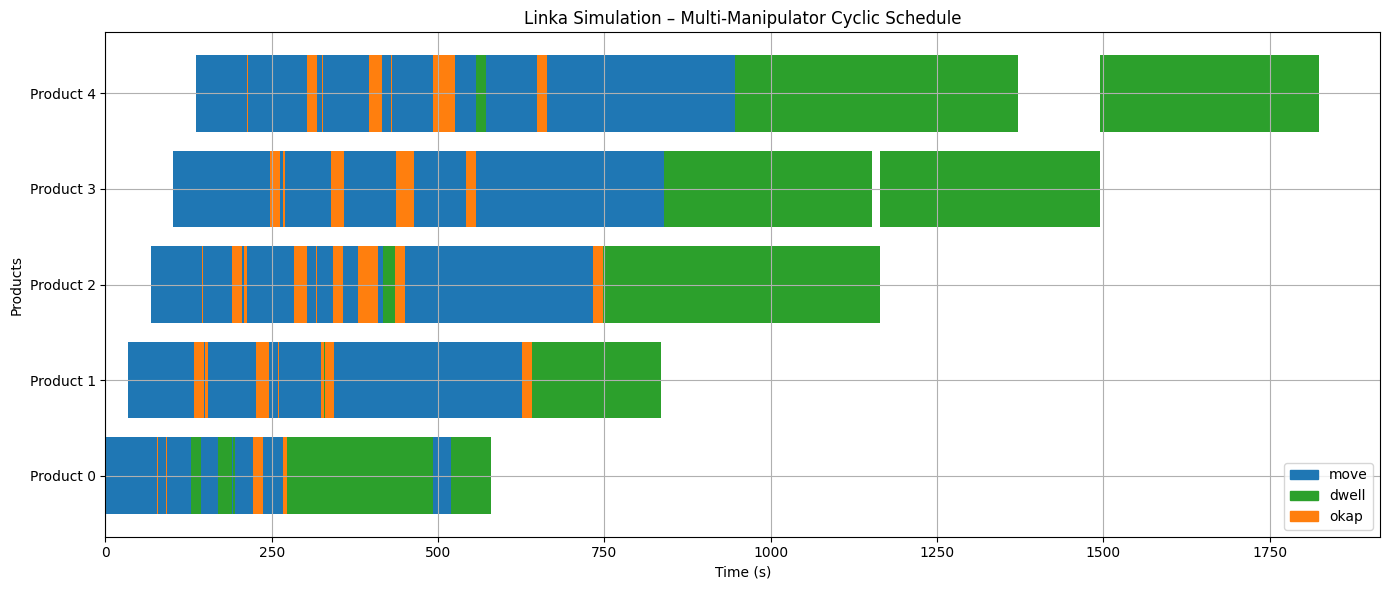

In [32]:
# Show outputs
print("Manipulator Ranges:", ranges)
print("Cycle Time:", schedule_df['cycle_time'].max())
print("\nCyclic Schedule:")
print(schedule_df)
print("\nSimulation Output with bath & collision logic:")
print(sim_df)

# Optionally visualize
plot_linka_gantt(sim_df)


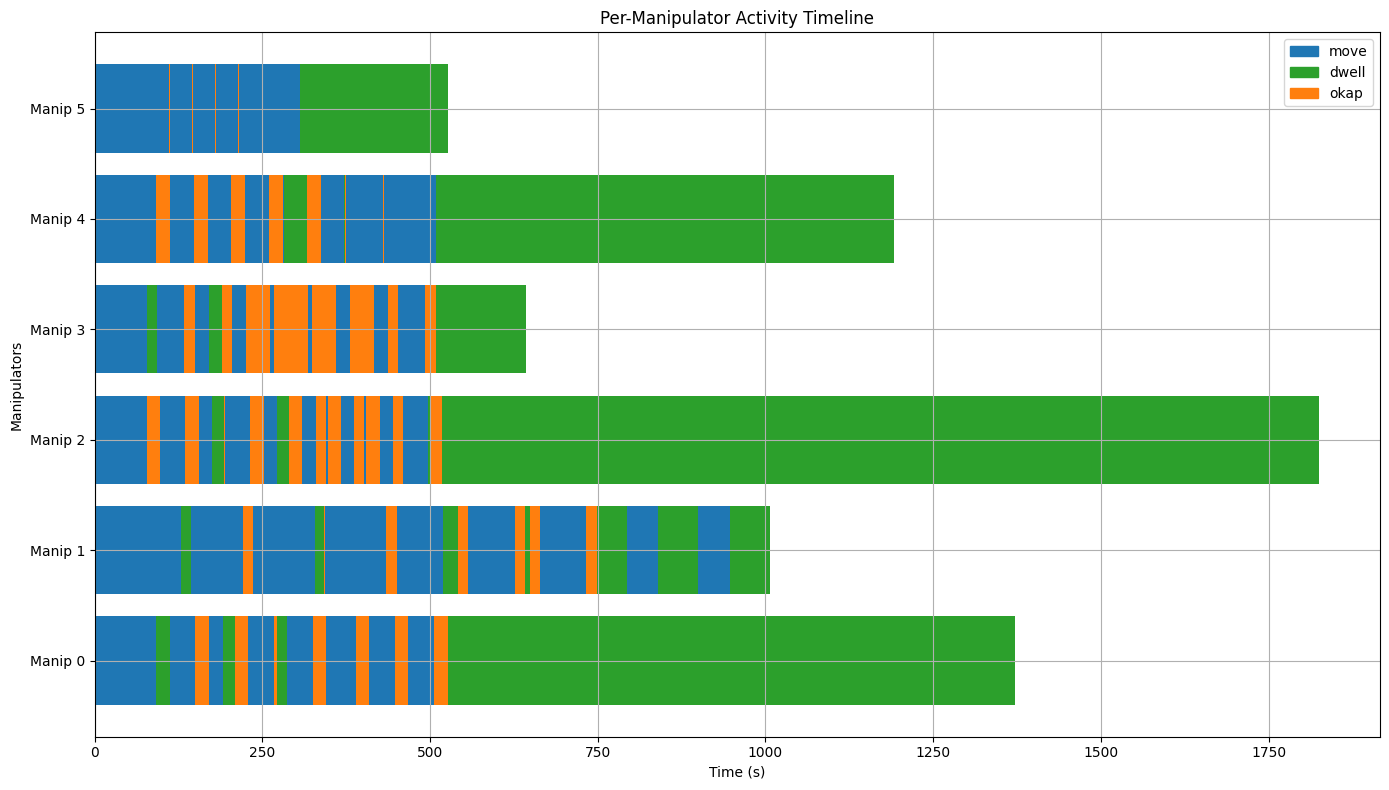

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_manipulator_timelines(sim_df):
    fig, ax = plt.subplots(figsize=(14, 8))
    manipulators = sim_df['manipulator'].dropna().unique()
    colors = {'move': 'tab:blue', 'dwell': 'tab:green', 'okap': 'tab:orange'}

    yticks = []
    ytick_labels = []

    for idx, man in enumerate(sorted(manipulators)):
        man_tasks = sim_df[sim_df['manipulator'] == man]
        for _, row in man_tasks.iterrows():
            ax.barh(y=idx, width=row['end'] - row['start'], left=row['start'],
                    color=colors.get(row['operation'], 'gray'))
        yticks.append(idx)
        ytick_labels.append(f'Manip {int(man)}')

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Manipulators")
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.set_title("Per-Manipulator Activity Timeline")
    ax.grid(True)

    legend_patches = [mpatches.Patch(color=color, label=op) for op, color in colors.items()]
    ax.legend(handles=legend_patches, loc='upper right')

    plt.tight_layout()
    plt.show()

# Run this if you already have sim_df from simulate_line_run_v2
plot_manipulator_timelines(sim_df)


In [38]:
def build_improved_cyclic_schedule(recept_df, tech, linka_df, speeds, n_manipulators):
    recipe = recept_df[recept_df['tech'] == tech].sort_values('poradi_operace')
    ordered_baths = recipe['id_vany'].tolist()

    all_steps = []
    for i in range(len(ordered_baths) - 1):
        src = ordered_baths[i]
        dst = ordered_baths[i + 1]
        move_time = compute_move_time(src, dst, linka_df, speeds)
        dwell_row = recipe[recipe['id_vany'] == dst].iloc[0]
        okap = dwell_row['okap']
        okap_time = dwell_row['okap_cas'] if okap else 0
        dwell_time = dwell_row['cas_opt']
        all_steps.append((src, dst, move_time, okap_time, dwell_time, okap))

    steps_split = np.array_split(all_steps, n_manipulators)
    schedule = []
    for m_id, step_group in enumerate(steps_split):
        time_cursor = 0
        for i, (src, dst, move_t, okap_t, dwell_t, okap) in enumerate(step_group):
            schedule.append({
                'manipulator': m_id,
                'step': i,
                'from': src,
                'to': dst,
                'start_time': time_cursor,
                'end_time': time_cursor + move_t,
                'move_time': move_t,
                'operation': 'move',
                'dwell_time': dwell_t
            })
            time_cursor += move_t

            if okap:
                schedule.append({
                    'manipulator': m_id,
                    'step': i,
                    'from': dst,
                    'to': dst,
                    'start_time': time_cursor,
                    'end_time': time_cursor + okap_t,
                    'move_time': okap_t,
                    'operation': 'okap',
                    'dwell_time': 0
                })
                time_cursor += okap_t

    schedule_df = pd.DataFrame(schedule)
    schedule_df['cycle_time'] = schedule_df.groupby('manipulator')['end_time'].transform('max')
    return schedule_df


In [39]:
import pandas as pd
import IPython.display as disp

# Define the display function
def show_schedule_per_manip(schedule_df):
    grouped = schedule_df.groupby('manipulator')
    for manip_id, group in grouped:
        print(f"\n=== Manipulator {manip_id} Schedule ===")
        disp.display(group.reset_index(drop=True))

# Then call it (assuming schedule_df already exists)
show_schedule_per_manip(schedule_df)



=== Manipulator 0 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,0,0,0.0,1.0,0.000000,91.714286,91.714286,move,120.0,292.285714
1,0,0,1.0,1.0,91.714286,111.714286,20.000000,okap,0.0,292.285714
2,0,1,1.0,2.0,111.714286,192.000000,80.285714,move,160.0,292.285714
3,0,2,2.0,3.0,192.000000,272.285714,80.285714,move,220.0,292.285714
4,0,2,3.0,3.0,272.285714,292.285714,20.000000,okap,0.0,292.285714



=== Manipulator 1 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,1,0,3.0,5.0,0.000000,128.857143,128.857143,move,60.0,534.428571
1,1,0,5.0,5.0,128.857143,143.857143,15.000000,okap,0.0,534.428571
2,1,1,5.0,6.0,143.857143,221.285714,77.428571,move,60.0,534.428571
3,1,1,6.0,6.0,221.285714,236.285714,15.000000,okap,0.0,534.428571
4,1,2,6.0,11.0,236.285714,519.428571,283.142857,move,60.0,534.428571
5,1,2,11.0,11.0,519.428571,534.428571,15.000000,okap,0.0,534.428571



=== Manipulator 2 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,2,0,11.0,12.0,0.000000,77.428571,77.428571,move,160.0,287.285714
1,2,0,12.0,12.0,77.428571,97.428571,20.000000,okap,0.0,287.285714
2,2,1,12.0,13.0,97.428571,174.857143,77.428571,move,330.0,287.285714
3,2,1,13.0,13.0,174.857143,194.857143,20.000000,okap,0.0,287.285714
4,2,2,13.0,14.0,194.857143,272.285714,77.428571,move,75.0,287.285714
5,2,2,14.0,14.0,272.285714,287.285714,15.000000,okap,0.0,287.285714



=== Manipulator 3 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,3,0,14.0,21.0,0.000000,77.428571,77.428571,move,75.0,282.285714
1,3,0,21.0,21.0,77.428571,92.428571,15.000000,okap,0.0,282.285714
2,3,1,21.0,15.0,92.428571,169.857143,77.428571,move,90.0,282.285714
3,3,1,15.0,15.0,169.857143,189.857143,20.000000,okap,0.0,282.285714
4,3,2,15.0,16.0,189.857143,267.285714,77.428571,move,75.0,282.285714
5,3,2,16.0,16.0,267.285714,282.285714,15.000000,okap,0.0,282.285714



=== Manipulator 4 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,4,0,16.0,17.0,0.000000,91.714286,91.714286,move,220.0,282.857143
1,4,0,17.0,17.0,91.714286,111.714286,20.000000,okap,0.0,282.857143
2,4,1,17.0,18.0,111.714286,203.428571,91.714286,move,90.0,282.857143
3,4,1,18.0,18.0,203.428571,204.428571,1.000000,okap,0.0,282.857143
4,4,2,18.0,19.0,204.428571,281.857143,77.428571,move,90.0,282.857143
5,4,2,19.0,19.0,281.857143,282.857143,1.000000,okap,0.0,282.857143



=== Manipulator 5 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,5,0,19.0,20.0,0.000000,77.428571,77.428571,move,90.0,170.142857
1,5,0,20.0,20.0,77.428571,78.428571,1.000000,okap,0.0,170.142857
2,5,1,20.0,100.0,78.428571,170.142857,91.714286,move,0.0,170.142857


final?

In [41]:
def build_smarter_cyclic_schedule(recept_df, tech, linka_df, speeds, n_manipulators):
    recipe = recept_df[recept_df['tech'] == tech].sort_values('poradi_operace')
    ordered_baths = recipe['id_vany'].tolist()

    all_steps = []
    for i in range(len(ordered_baths) - 1):
        src = ordered_baths[i]
        dst = ordered_baths[i + 1]
        move_time = compute_move_time(src, dst, linka_df, speeds)
        dwell_row = recipe[recipe['id_vany'] == dst].iloc[0]
        okap = dwell_row['okap']
        okap_time = dwell_row['okap_cas'] if okap else 0
        dwell_time = dwell_row['cas_opt']
        all_steps.append({
            'from': src,
            'to': dst,
            'move_time': move_time,
            'dwell_time': dwell_time,
            'okap': okap,
            'okap_time': okap_time
        })

    steps_split = np.array_split(all_steps, n_manipulators)
    schedule = []

    for m_id, step_group in enumerate(steps_split):
        time_cursor = 0
        skip_return = False

        for i, step in enumerate(step_group):
            src = step['from']
            dst = step['to']

            # Optimization: If the previous bath is done with dwell, skip returning
            if i > 0:
                prev_step = step_group[i - 1]
                prev_dwell = prev_step['dwell_time']
                prev_okap = prev_step['okap_time']
                wait_time = prev_dwell + prev_okap
                if wait_time <= step['move_time']:
                    skip_return = True

            if not skip_return:
                # Regular move
                schedule.append({
                    'manipulator': m_id,
                    'step': i,
                    'from': src,
                    'to': dst,
                    'start_time': time_cursor,
                    'end_time': time_cursor + step['move_time'],
                    'move_time': step['move_time'],
                    'operation': 'move',
                    'dwell_time': step['dwell_time']
                })
                time_cursor += step['move_time']
            else:
                # Optimized skip move (assumes item is ready at dst)
                schedule.append({
                    'manipulator': m_id,
                    'step': i,
                    'from': dst,
                    'to': dst,
                    'start_time': time_cursor,
                    'end_time': time_cursor + step['move_time'],
                    'move_time': step['move_time'],
                    'operation': 'pickup_direct',
                    'dwell_time': step['dwell_time']
                })
                time_cursor += step['move_time']
                skip_return = False

            # Okap if needed
            if step['okap']:
                schedule.append({
                    'manipulator': m_id,
                    'step': i,
                    'from': dst,
                    'to': dst,
                    'start_time': time_cursor,
                    'end_time': time_cursor + step['okap_time'],
                    'move_time': step['okap_time'],
                    'operation': 'okap',
                    'dwell_time': 0
                })
                time_cursor += step['okap_time']

    schedule_df = pd.DataFrame(schedule)
    schedule_df['cycle_time'] = schedule_df.groupby('manipulator')['end_time'].transform('max')
    return schedule_df


In [42]:
schedule_df = build_smarter_cyclic_schedule(
    recept_df,
    tech,
    linka_df,
    manipulator_characteristics,
    N_MANIPULATORS
)


In [43]:
show_schedule_per_manip(schedule_df)



=== Manipulator 0 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,0,0,0,1,0.000000,91.714286,91.714286,move,120,292.285714
1,0,0,1,1,91.714286,111.714286,20.000000,okap,0,292.285714
2,0,1,1,2,111.714286,192.000000,80.285714,move,160,292.285714
3,0,2,2,3,192.000000,272.285714,80.285714,move,220,292.285714
4,0,2,3,3,272.285714,292.285714,20.000000,okap,0,292.285714



=== Manipulator 1 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,1,0,3,5,0.000000,128.857143,128.857143,move,60,534.428571
1,1,0,5,5,128.857143,143.857143,15.000000,okap,0,534.428571
2,1,1,6,6,143.857143,221.285714,77.428571,pickup_direct,60,534.428571
3,1,1,6,6,221.285714,236.285714,15.000000,okap,0,534.428571
4,1,2,11,11,236.285714,519.428571,283.142857,pickup_direct,60,534.428571
5,1,2,11,11,519.428571,534.428571,15.000000,okap,0,534.428571



=== Manipulator 2 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,2,0,11,12,0.000000,77.428571,77.428571,move,160,287.285714
1,2,0,12,12,77.428571,97.428571,20.000000,okap,0,287.285714
2,2,1,12,13,97.428571,174.857143,77.428571,move,330,287.285714
3,2,1,13,13,174.857143,194.857143,20.000000,okap,0,287.285714
4,2,2,13,14,194.857143,272.285714,77.428571,move,75,287.285714
5,2,2,14,14,272.285714,287.285714,15.000000,okap,0,287.285714



=== Manipulator 3 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,3,0,14,21,0.000000,77.428571,77.428571,move,75,282.285714
1,3,0,21,21,77.428571,92.428571,15.000000,okap,0,282.285714
2,3,1,21,15,92.428571,169.857143,77.428571,move,90,282.285714
3,3,1,15,15,169.857143,189.857143,20.000000,okap,0,282.285714
4,3,2,15,16,189.857143,267.285714,77.428571,move,75,282.285714
5,3,2,16,16,267.285714,282.285714,15.000000,okap,0,282.285714



=== Manipulator 4 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,4,0,16,17,0.000000,91.714286,91.714286,move,220,282.857143
1,4,0,17,17,91.714286,111.714286,20.000000,okap,0,282.857143
2,4,1,17,18,111.714286,203.428571,91.714286,move,90,282.857143
3,4,1,18,18,203.428571,204.428571,1.000000,okap,0,282.857143
4,4,2,18,19,204.428571,281.857143,77.428571,move,90,282.857143
5,4,2,19,19,281.857143,282.857143,1.000000,okap,0,282.857143



=== Manipulator 5 Schedule ===


,manipulator,step,from,to,start_time,end_time,move_time,operation,dwell_time,cycle_time
0,5,0,19,20,0.000000,77.428571,77.428571,move,90,170.142857
1,5,0,20,20,77.428571,78.428571,1.000000,okap,0,170.142857
2,5,1,100,100,78.428571,170.142857,91.714286,pickup_direct,0,170.142857


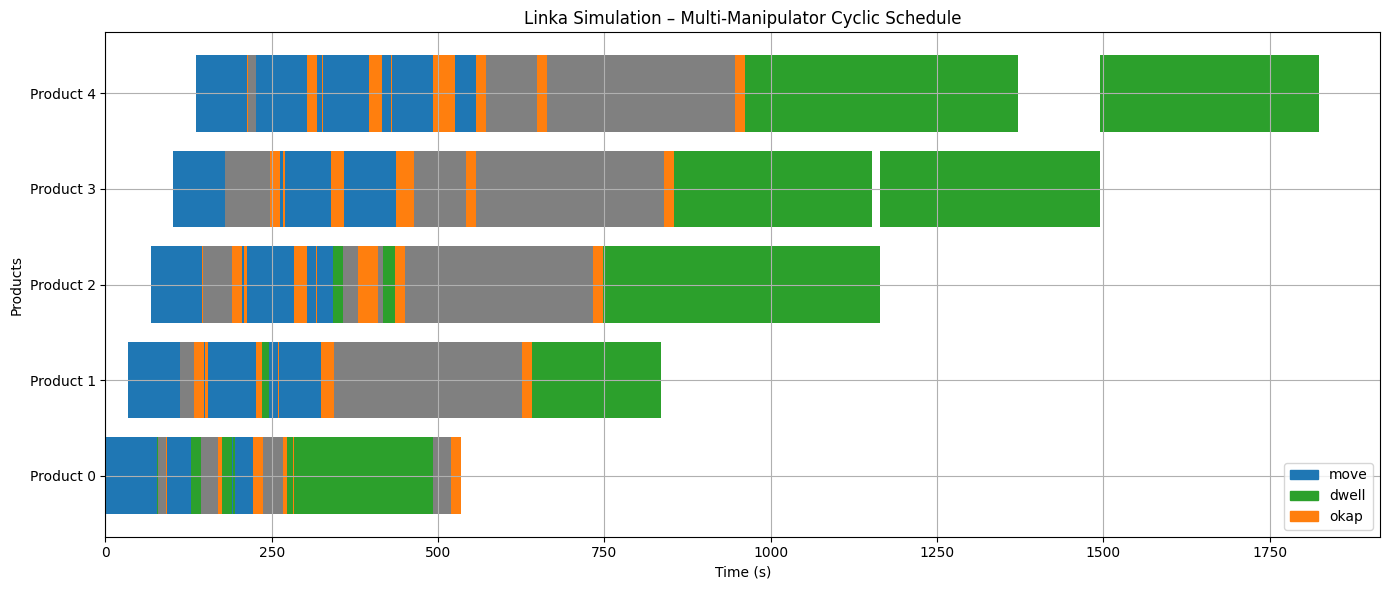

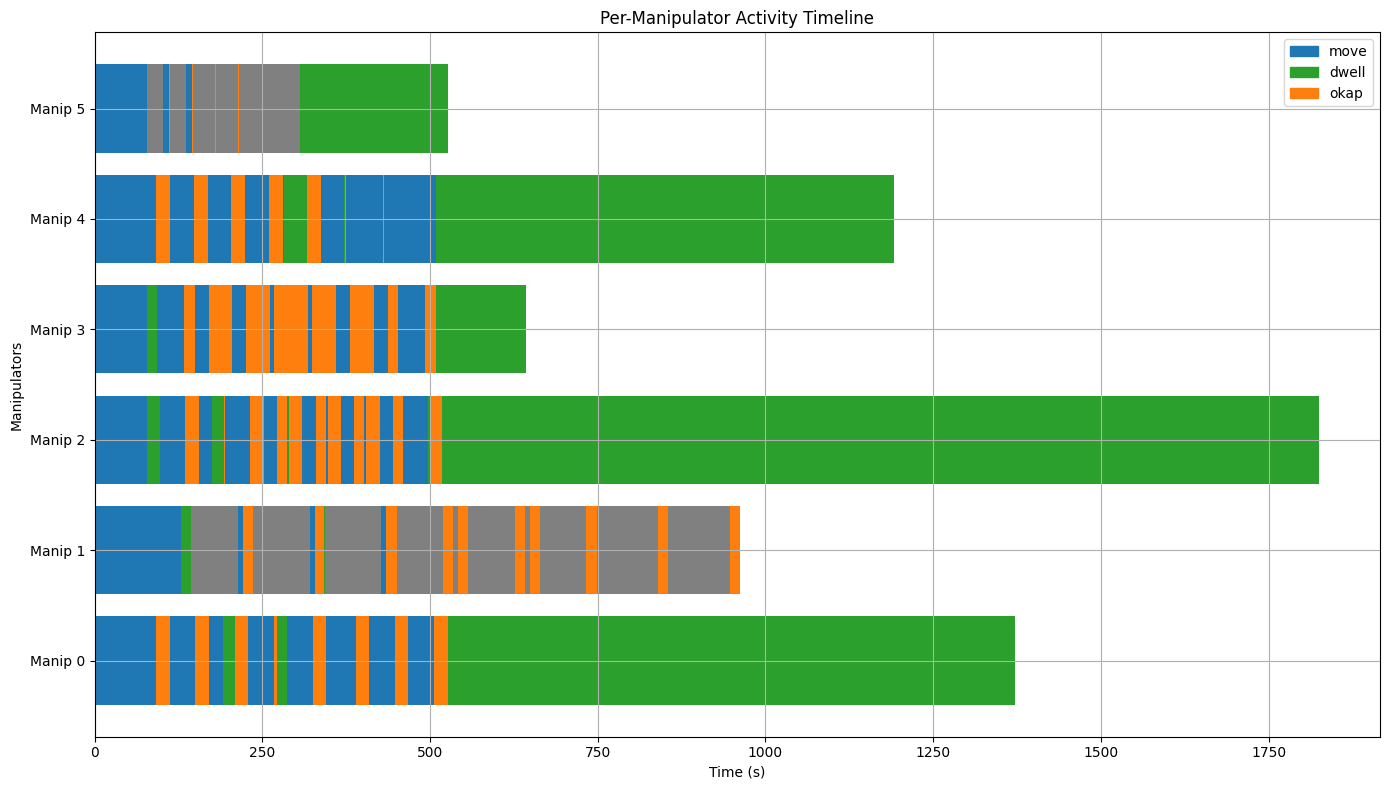

In [44]:
sim_df = simulate_line_run_v2(schedule_df, N_MANIPULATORS, NUM_PRODUCTS, linka_df)
plot_linka_gantt(sim_df)
plot_manipulator_timelines(sim_df)


In [45]:
NUM_PRODUCTS = 10  # Set number of products

# Run simulation with your smart cyclic schedule
sim_df = simulate_line_run_v2(schedule_df, N_MANIPULATORS, NUM_PRODUCTS, linka_df)

# Print results
print("\nSimulation Output for 10 Products:")
print(sim_df)


Simulation Output for 10 Products:
     product  manipulator operation  from  to        start          end  cycle
0          0            0      move     0   1     0.000000    91.714286      0
1          0            4      move    16  17     0.000000    91.714286      0
2          0            5      move    19  20     0.000000    77.428571      0
3          0            2      move    11  12     0.000000    77.428571      0
4          0            3      move    14  21     0.000000    77.428571      0
..       ...          ...       ...   ...  ..          ...          ...    ...
455        5            1      okap    11  11   786.642857   801.642857      1
456        6            1      okap    11  11   840.085714   855.085714      1
457        7            1      okap    11  11   893.528571   908.528571      1
458        8            1      okap    11  11   946.971429   961.971429      1
459        9            1      okap    11  11  1000.414286  1015.414286      1

[460 rows x 8 c

In [46]:
from google.colab import drive
drive.mount('/content/drive')

sim_df.to_excel("/content/drive/MyDrive/simulation_output_10_products.xlsx", index=False)


Mounted at /content/drive
